In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import scipy.io as sio

from utils import *
from generateData import generateSynthData

In [75]:
n = 200
nSamples = 5000

M = 1
synthetic_data = generateSynthData(d_list=[n], p=0.07, M=M, N=nSamples, dim_percent=0.8)

  0%|          | 0/1 [00:00<?, ?it/s]

Number of Nodes: 200
Generating adj. matrices
Sampling direct observations


100%|██████████| 1/1 [00:00<00:00, 97.78it/s]

Constructing the measurement matrix
changed scale
Generating the indirect measurements


In [72]:
def constructSensingMatUP(lambda_vec_h, lambda_vec_l, dch, dcl, nh, nl, A=1):
    dvh = len(lambda_vec_h)
    dvl = len(lambda_vec_l)
    
    m = int(np.round((nh * np.arange(1, dvh+1).reshape(1, dvh) @ lambda_vec_h + nl * np.arange(1, dvl+1).reshape(1, dvl) @ lambda_vec_l)/(dch + dcl)))
    A_mat = np.zeros((m, nh+nl))
    
    # Construct the high priority connections part
    col_deg_high = np.round(nh * lambda_vec_h)
    
    excessN = col_deg_high.sum() - nh
    # print(excessN)
    i = 1
    while excessN > 0:
        if col_deg_high[i] > 0:
            col_deg_high[i] -= 1
        i += 1
        excessN = col_deg_high.sum() - nh
        
    i = 1
    while excessN < 0:
        col_deg_high[i] += 1
        i += 1
        excessN = col_deg_high.sum() - nh
        
    # print(col_deg_high)
    
    colDegree = np.zeros(nh)
    cols = list(range(nh))
    for i in range(dvh):
        if col_deg_high[i] == 0:
            continue
        
        sampledCols = np.random.choice(cols, int(col_deg_high[i]), replace=False)
        colDegree[sampledCols] = i+1
        cols = list((set(cols)).difference(set(sampledCols)))
    
    nEdges = m*dch
    excessEdges = colDegree.sum() - nEdges
    # print(excessEdges)
    i = 0
    while excessEdges > 0:
        if i == nh:
            i = 0
        colDegree[nh-1-i] -= 1
        i += 1
        excessEdges = colDegree.sum() - nEdges
    
    i = 0
    while excessEdges < 0:
        if i == nh:
            i = 0
        colDegree[nh-1-i] += 1
        i += 1
        excessEdges = colDegree.sum() - nEdges
        
    colDegDict = { c: deg for c, deg in enumerate(colDegree)}
    availCols = lambda x: [k for k in x if x[k] > 0]
    
    for row in range(m):
        freeCols = availCols(colDegDict)
        sampledCols = np.random.choice(freeCols, dch, replace=False)
        A_mat[row, sampledCols] = 1

        
    # Constructing the low priority part
    
    col_deg_low = np.round(nl * lambda_vec_l)
    
    excessN = col_deg_low.sum() - nl
    i = 1
    while excessN > 0:
        if col_deg_low[i] > 0:
            col_deg_low[i] -= 1
        i += 1
        excessN = col_deg_low.sum() - nl
        
    i = 1
    while excessN < 0:
        col_deg_low[i] += 1
        i += 1
        excessN = col_deg_low.sum() - nl
    
    colDegree = np.zeros(nl)
    cols = list(range(nl))
    for i in range(dvl):
        if col_deg_low[i] == 0:
            continue
        
        sampledCols = np.random.choice(cols, int(col_deg_low[i]), replace=False)
        colDegree[sampledCols] = i+1
        cols = list((set(cols)).difference(set(sampledCols)))
    
    nEdges = m*dcl
    excessEdges = colDegree.sum() - nEdges
    i = 0
    while excessEdges > 0:
        if i == nl:
            i = 0
        colDegree[nl-1-i] -= 1
        i += 1
        excessEdges = colDegree.sum() - nEdges
    
    i = 0
    while excessEdges < 0:
        if i == nl:
            i = 0
        colDegree[nl-1-i] += 1
        i += 1
        excessEdges = colDegree.sum() - nEdges
        
    colDegDict = { c: deg for c, deg in enumerate(colDegree)}
    availCols = lambda x: [k for k in x if x[k] > 0]
    
    for row in range(m):
        freeCols = availCols(colDegDict)
        sampledCols = np.random.choice(freeCols, dch, replace=False)
        modsampledCols = [col + nh for col in sampledCols]
        A_mat[row, modsampledCols] = 1
        
    A_mat = A_mat * (2 * (np.random.rand(m, nh + nl) > 0.5) - 1) * (1/A)**0.5
        
    return A_mat

In [83]:
lambda_h.T @ np.arange(40).reshape(40, 1)

array([[5.00000001]])

In [82]:
lambda_h.shape

(40, 1)

Sensing matrix shape: (43, 200)


Text(0.5, 1.0, 'Baseline Sensing Matrix')

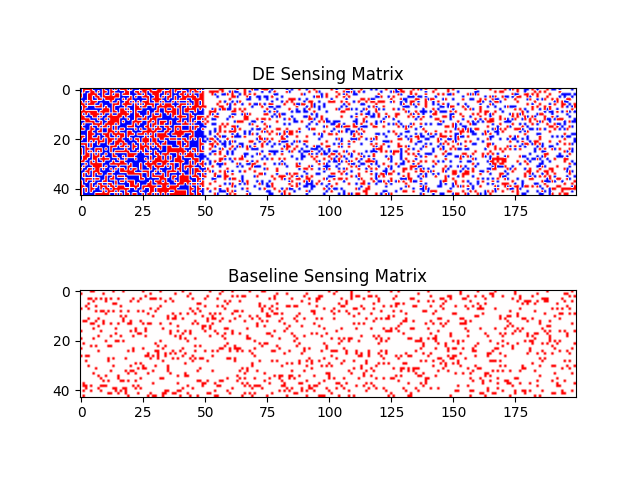

In [135]:
lambda_h = sio.loadmat("lambda_h_2.mat")['lambda_h']
lambda_l = sio.loadmat("lambda_l_2.mat")["lambda_l"]

A = getSensingMatrixUP(lambda_h, lambda_l, dch=50, dcl=50, nh=50, nl=150, A=1.0)
A_bs = generateA(A.shape[0], A.shape[1], delta=6)
print("Sensing matrix shape: {}".format(A.shape))

%matplotlib widget

fig, axs = plt.subplots(2, 1)

im = axs[0].imshow(A, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_title("DE Sensing Matrix")
im = axs[1].imshow(A_bs, cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title("Baseline Sensing Matrix")
# cbar = plt.colorbar(im)

In [136]:
nl = 150
nh = 50

X = synthetic_data[n]['X'][0]
W = synthetic_data[n]['W'][0]

Cov_X = np.linalg.inv(np.eye(n) - W.T) @ np.linalg.inv(np.eye(n) - W.T).T 

In [137]:
(np.abs(Cov_X[nh:,nh:]) > 0).sum()

1406

In [138]:



Cov_X_hh = Cov_X[:nh, :nh]

Y = X @ A.T
Y_bs = X @ A_bs.T

S_y = (1/nSamples) * Y.T @ Y 
Cov_X_hat_de = covarianceEstimate(S_y, A, pen_coeff=0.5, noise=True)
Cov_x_hat_de_hh = Cov_X_hat_de[:nh, :nh]

S_y_bs = (1/nSamples) * Y_bs.T @ Y_bs 
Cov_x_hat_bs = covarianceEstimate(S_y_bs, A_bs, pen_coeff=0.5, noise=True)
Cov_x_hat_bs_hh = Cov_x_hat_bs[:nh, :nh]

In [139]:
Cov_X_hh = Cov_X[:nh, :nh]
Cov_x_hat_de_hh = Cov_X_hat_de[:nh, :nh]
Cov_x_hat_bs_hh = Cov_x_hat_bs[:nh, :nh]

In [140]:
print("DE Error, Fro: {}, MAE: {}".format(np.linalg.norm(Cov_X_hh - Cov_x_hat_de_hh, 'fro'), np.abs(Cov_X_hh - Cov_x_hat_de_hh).max()))
print("BS Error, Fro: {}, MAE: {}".format(np.linalg.norm(Cov_X_hh - Cov_x_hat_bs_hh, 'fro'), np.abs(Cov_X_hh - Cov_x_hat_bs_hh).max()))

DE Error, Fro: 3.445278998684756, MAE: 0.7658913320430996
BS Error, Fro: 4.145248750836302, MAE: 1.046899321916511


In [16]:
S_x = (1/nSamples) * X.T @ X 
S_x_hh = S_x[:nh, :nh]

print(np.linalg.norm(Cov_X_hh - S_x_hh, 'fro'))

0.7967294532978965
